# Importación de bibliotecas

In [1]:
import numpy as np
import pandas as pd
from copy import copy
import random
import os                                                 
import sys
import dowhy
from dowhy import CausalModel
module_path = os.path.abspath(os.path.join('../server'))                                                      
if module_path not in sys.path:                        
    sys.path.append(module_path)                    
from expertSystem.expertSystem import getCandidateBeers

# Generación de DataSet sintético

In [2]:
INTENSITY_TYPES = ["baja", "media", "alta"]
COLOR_TYPES = ["palido", "ambar", "oscuro"]
BITTERNESS_TYPES = ["bajo", "medio", "alto"]
HOP_TYPES = ["viejo mundo", "nuevo mundo"]
FERMENTATION_TYPES = ["baja", "media", "alta"]
YEAST_TYPES = ["lager", "ale"]

In [3]:
NUM_CLIENTS = 10000

feature_types = {
    'intensity': INTENSITY_TYPES,
    'color': COLOR_TYPES,
    'bitterness': BITTERNESS_TYPES,
    'hop': HOP_TYPES,
    'fermentation': FERMENTATION_TYPES,
    'yeast': YEAST_TYPES,
}
template = {
    'intensity': '*',
    'color': '*',
    'bitterness': '*',
    'hop': '*',
    'fermentation': '*',
    'yeast': '*'
}
features = list(template.keys())

responses = []
for client_idx in range(NUM_CLIENTS):
    response = copy(template)
    random.shuffle(features)
    for feature in features:
        response[feature] = random.choice(feature_types[feature])
        engine_result = getCandidateBeers(response)
        candidates = engine_result['candidateBeers']
        if not candidates:
            response['beer'] = 'None'
            responses.append(response)
            break
        if len(candidates) == 1:
            response['beer'] = candidates[0]
            responses.append(response)
            break

result_df = pd.DataFrame(responses)
result_df.head(10)

,intensity,color,bitterness,hop,fermentation,yeast,beer
0,*,*,*,viejo mundo,*,ale,Kolsch
1,media,*,bajo,*,alta,*,Kolsch
2,media,oscuro,*,viejo mundo,*,*,Lager Ambar Checa
3,*,*,medio,*,baja,*,Lager Ambar Checa
4,*,*,*,*,alta,lager,None
5,*,*,*,*,baja,*,Lager Ambar Checa
6,baja,*,*,nuevo mundo,*,*,Cream Ale
7,baja,palido,*,*,alta,ale,None
8,*,oscuro,*,*,*,ale,None
9,media,*,*,nuevo mundo,*,*,Cream Ale


In [4]:
result_df['color'].unique()

array(['*', 'oscuro', 'palido', 'ambar'], dtype=object)

# Análisis de inferencia causal

In [5]:
intensity_mapping = {"*":0,"baja":1,"media":2,"alta":3}
color_mapping = {'*': 0, 'palido': 1, 'oscuro': 2, 'ambar': 3}
bitterness_mapping = {"*":0,"bajo":1,"medio":2,"alto":3}
hop_mapping ={"*": 0, "viejo mundo" : 1, "nuevo mundo": 2}
fermentation_mapping = intensity_mapping
yeast_mapping = {"*":0, "lager":1, "ale":2}
beer_mapping = {'Cream Ale': 0, 'None': 1,'Kolsch': 2, 'Lager Ambar Checa': 3, 'Baltic Porter': 4, 'Ipa Blanca': 5}

result_df = result_df.replace({
    'intensity': intensity_mapping,
    'color': color_mapping,
    'bitterness': bitterness_mapping,
    'hop': hop_mapping,
    'fermentation': fermentation_mapping,
    'yeast': yeast_mapping,
    'beer': beer_mapping
})
result_df

,intensity,color,bitterness,hop,fermentation,yeast,beer
0,0,0,0,1,0,2,2
1,2,0,1,0,3,0,2
2,2,2,0,1,0,0,3
3,0,0,2,0,1,0,3
4,0,0,0,0,3,1,1
...,...,...,...,...,...,...,...
9995,0,0,0,2,2,0,0
9996,0,0,0,2,3,2,5
9997,0,0,3,0,0,0,5
9998,2,1,2,2,0,0,0


/home/franco/.local/lib/python3.10/site-packages/dowhy/causal_model.py:557: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


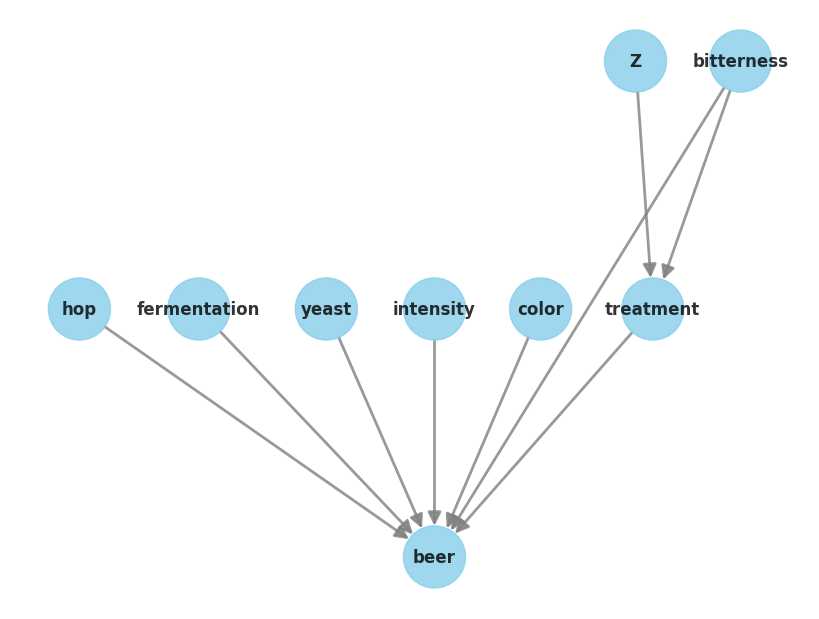

In [8]:
target_feature='yeast'
target_df = result_df.copy()
target_df['treatment'] = (result_df['intensity'] != 0) & (result_df['color'] != 0) & (result_df['bitterness'] != 0)

causal_graph = """digraph {
                    hop;
                    fermentation;
                    yeast;
                    
                    intensity;
                    color;
                    bitterness;

                    treatment;

                    hop->beer;
                    fermentation->beer;
                    yeast->beer;
                    intensity->beer;
                    color->beer;
                    bitterness->beer;
                    treatment->beer;
                    Z->treatment;
                    bitterness->treatment;
                    }
               """ 
#causal_graph = causal_graph + target_feature + "->treatment;}"
model = dowhy.CausalModel(data=target_df,
                          graph=causal_graph.replace("\n", " "),
                          treatment="treatment",
                          outcome="beer")
model.view_model()

In [9]:
#ATE
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)
estimate = model.estimate_effect(identified_estimand,
                                 method_name='backdoor.propensity_score_matching',
                                 target_units='att')
print(estimate)
refutation = model.refute_estimate(identified_estimand, 
                                   estimate, 
                                   method_name='placebo_treatment_refuter',
                                   placebo_type='permute', 
                                   num_simulations=20)
print(refutation)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                          
────────────(E[beer|bitterness])
d[treatment]                    
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→beer then P(beer|treatment,bitterness,U) = P(beer|treatment,bitterness)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢ d         ⎛ d               ⎞  ⎥
E⎢────(beer)⋅⎜────([treatment])⎟  ⎥
 ⎣d[Z]       ⎝d[Z]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→beer then ¬(U →→{Z})
Estimand assumption 2, Exclusion: If we remove {Z}→{treatment}, then ¬({Z}→beer)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                          
────────────(E[beer|bitterness])
d[treatment]    